In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import keras.layers as L
import sklearn
%matplotlib inline

In [6]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data.shape

(244768, 12)

In [7]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
46853,68570446,Nurse (Nights ) Nursing Home RGN,Nurse (RGN) Elderly Nursing Home Warwickshire...,Warwickshire - Alcester,Alcester,full_time,permanent,UKStaffsearch,Healthcare & Nursing Jobs,23000 - 25000,24000,ukstaffsearch.com
208677,72159275,Mechanical Design EngineerPower Systems,Mechanical Design EngineerPower Systems This h...,Berkshire,Berkshire,full_time,permanent,Forest Personnel,Other/General Jobs,"From 30,000 to 35,000 per year",32500,JustLondonJobs
63748,68704980,Internal Recruiter,Our client is looking to appoint an experience...,East Midlands,East Midlands,NaN,permanent,Astralis Recruitment Group Ltd,HR & Recruitment Jobs,"Up to 35,000 per annum",35000,totaljobs.com


In [8]:
data["Category"].value_counts()

IT Jobs                             38483
Engineering Jobs                    25174
Accounting & Finance Jobs           21846
Healthcare & Nursing Jobs           21076
Sales Jobs                          17272
Other/General Jobs                  17055
Teaching Jobs                       12637
Hospitality & Catering Jobs         11351
PR, Advertising & Marketing Jobs     8854
Trade & Construction Jobs            8837
HR & Recruitment Jobs                7713
Admin Jobs                           7614
Retail Jobs                          6584
Customer Services Jobs               6063
Legal Jobs                           3939
Manufacturing Jobs                   3765
Logistics & Warehouse Jobs           3633
Social work Jobs                     3455
Consultancy Jobs                     3263
Travel Jobs                          3126
Scientific & QA Jobs                 2489
Charity & Voluntary Jobs             2332
Energy, Oil & Gas Jobs               2255
Creative & Design Jobs            

<AxesSubplot:ylabel='Frequency'>

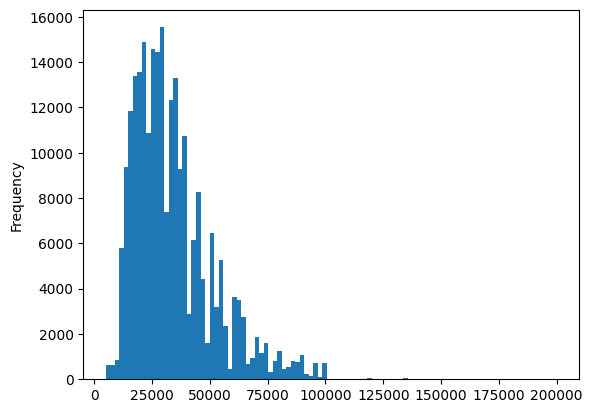

In [9]:
data["SalaryNormalized"].plot(kind="hist", bins=100)

<AxesSubplot:ylabel='Frequency'>

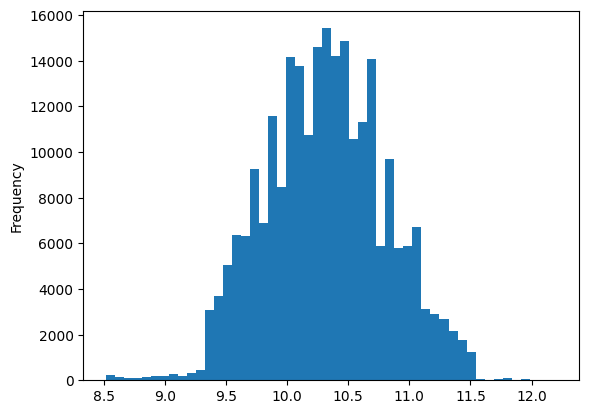

In [10]:
data["log_salary"] = np.log(data["SalaryNormalized"])
data["log_salary"].plot(kind="hist", bins=50)

In [11]:
from sklearn.preprocessing import KBinsDiscretizer
kb = KBinsDiscretizer(
    n_bins=5, 
    encode="ordinal", 
    strategy="quantile"
).fit(data[["log_salary"]])

C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_discretization.py:209: FutureWarning: In version 1.3 onwards, subsample=2e5 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


In [12]:
kb.bin_edges_

array([array([ 8.51719319,  9.88593439, 10.18490001, 10.45045222, 10.71441777,
              12.20607265])                                                   ],
      dtype=object)

<AxesSubplot:ylabel='Frequency'>

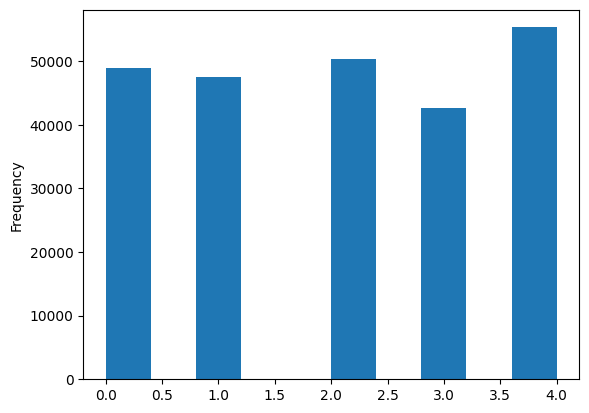

In [13]:
data["log_salary_cat"] = kb.transform(data[["log_salary"]]).ravel()
data["log_salary_cat"].plot(kind="hist")

In [14]:
data[["Category", "log_salary_cat"]].value_counts()

Category                       log_salary_cat
IT Jobs                        4.0               16412
                               3.0                9653
Accounting & Finance Jobs      4.0                7223
Engineering Jobs               2.0                7134
IT Jobs                        2.0                6673
                                                 ...  
Part time Jobs                 4.0                   2
                               3.0                   2
                               1.0                   2
Domestic help & Cleaning Jobs  4.0                   1
Part time Jobs                 2.0                   1
Length: 145, dtype: int64

In [15]:
data["Category_temp"] = data["Category"]
data["Category_temp"].replace({"Domestic help & Cleaning Jobs" : "Other", "Part time Jobs": "Other"}, inplace=True)
data[["Category_temp", "log_salary_cat"]].value_counts()

Category_temp              log_salary_cat
IT Jobs                    4.0               16412
                           3.0                9653
Accounting & Finance Jobs  4.0                7223
Engineering Jobs           2.0                7134
IT Jobs                    2.0                6673
                                             ...  
Maintenance Jobs           4.0                  38
Other                      3.0                  18
                           1.0                  17
                           2.0                  16
                           4.0                   3
Length: 140, dtype: int64

In [16]:
from sklearn.model_selection import train_test_split
y = data["log_salary"]
X = data.drop(columns=["log_salary", "log_salary_cat", "Category_temp", "SalaryRaw", "SalaryNormalized"])
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.1, random_state=42,
    stratify=data[["Category_temp", "log_salary_cat"]]
)

In [17]:
for col in ["Title", "Company", "ContractTime", "ContractType", "SourceName"]:
    X_train[col].fillna("", inplace=True)
    X_train[col] = X_train[col].astype("str")
    X_val[col] = X_val[col].astype("str")

train_ds = tf.data.Dataset.from_tensor_slices((dict(X_train), y_train)) 
val_ds = tf.data.Dataset.from_tensor_slices((dict(X_val), y_val)) 

In [18]:
train_ds = train_ds.batch(32).prefetch(1)
val_ds = val_ds.batch(32).prefetch(1)

In [19]:
del X, y, X_train, X_val, y_train, y_val, data, kb

# Preprocessing 

In [20]:
from keras.layers import StringLookup

def encode_categorical_feature(feature, name, dataset, max_tokens=200, num_oov_indices=10):
    lookup = StringLookup(output_mode="binary", max_tokens=max_tokens, num_oov_indices=num_oov_indices)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [21]:
import gensim 
from keras.layers import TextVectorization
from keras.layers import Embedding

def encode_text_feature(
    feature, name, dataset, 
    wv_model: gensim.models.keyedvectors.KeyedVectors, 
    output_sequence_length=None,
    embedding_dim=300, max_tokens=20000
):
    vectorizer = TextVectorization(
        max_tokens=max_tokens,
        output_sequence_length=output_sequence_length
    )
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    vectorizer.adapt(feature_ds)
    vectorized_feature = vectorizer(feature)
    
    vocab = np.array(vectorizer.get_vocabulary())
    index_to_token = {vectorizer(w).numpy()[0]: w for w in vocab[1:] }
    index_to_token[0] = vocab[0]

    embedding_matrix = np.zeros((max_tokens, embedding_dim))
#     unmatched_words = []

    for i in range(max_tokens):
        word_i = index_to_token[i]
        if wv_model.has_index_for(word_i):
            embedding_matrix[i] = wv_model.get_vector(word_i)
#         else:
#             unmatched_words.append(word_i)

    embedding = Embedding(
        input_dim=max_tokens,
        output_dim=embedding_dim,
        embeddings_initializer=keras.initializers.Constant(embedding_matrix),
        # Use masking to handle the variable sequence lengths
        mask_zero=True,
        trainable=False
    )
    return embedding(vectorized_feature)

In [22]:
import gensim.downloader as api

wv_model = api.load("glove-wiki-gigaword-300")
title = keras.Input(shape=(1,), name="Title", dtype=tf.string)
enc_title = encode_text_feature(title, "Title", train_ds, wv_model=wv_model, max_tokens=5000)

The following cell takes quite some time to run, for it learns the encodings for our text and cat features -- this includes tokenizing, counting, embedding.

In [23]:
title = keras.Input(shape=(1,), name="Title", dtype=tf.string)
description = keras.Input(shape=(1,), name="FullDescription", dtype=tf.string)

title_enc = encode_text_feature(title, "Title", train_ds, wv_model, max_tokens=5000)
description_enc = encode_text_feature(description, "FullDescription", train_ds, wv_model, max_tokens=20000)

category = keras.Input(shape=(1,), name="Category", dtype=tf.string)
company = keras.Input(shape=(1,), name="Company", dtype=tf.string)
location = keras.Input(shape=(1,), name="LocationNormalized", dtype=tf.string)
contract_type = keras.Input(shape=(1,), name="ContractType", dtype=tf.string)
contract_time = keras.Input(shape=(1,), name="ContractTime", dtype=tf.string)

category_enc = encode_categorical_feature(category, "Category", train_ds)
company_enc = encode_categorical_feature(company, "Company", train_ds)
location_enc = encode_categorical_feature(location, "LocationNormalized", train_ds)
contract_type_enc = encode_categorical_feature(contract_type, "ContractType", train_ds)
contract_time_enc = encode_categorical_feature(contract_time, "ContractTime", train_ds)
cat_feats = keras.layers.concatenate([
    category_enc, company_enc, 
    location_enc, contract_type_enc,
    contract_time_enc
], axis=1)

In [23]:
def build_rnn_model():
    """ Build a model that maps three encoded data sources to a single linear output: predicted log1p(salary) """
    title_rnn = keras.layers.LSTM(128)(title_enc)
    descr_rnn = keras.layers.LSTM(128)(description_enc)
    
    dense_cat_1 = keras.layers.Dense(units=300, activation="relu")(cat_feats)
    dense_cat_2 = keras.layers.Dense(units=200, activation="relu")(dense_cat_1)
    dense_cat_3 = keras.layers.Dense(units=128, activation="relu")(dense_cat_2)
    
    concat = keras.layers.Concatenate(axis=1)([title_rnn, descr_rnn, dense_cat_3])
    dense_1 = keras.layers.Dense(units=300, activation="relu")(concat)
    dense_2 = keras.layers.Dense(units=300, activation="relu")(dense_1)
    dropout = keras.layers.Dropout(0.5)(dense_2)
    output_layer = keras.layers.Dense(units=1, activation="linear")(dropout)
    
    model = keras.models.Model(
        inputs=[
            title, description, 
            category, company,
            location, contract_type,
            contract_time
        ], 
        outputs=[output_layer])
    model.compile(keras.optimizers.Adam(), 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [24]:
rnn_model = build_rnn_model()

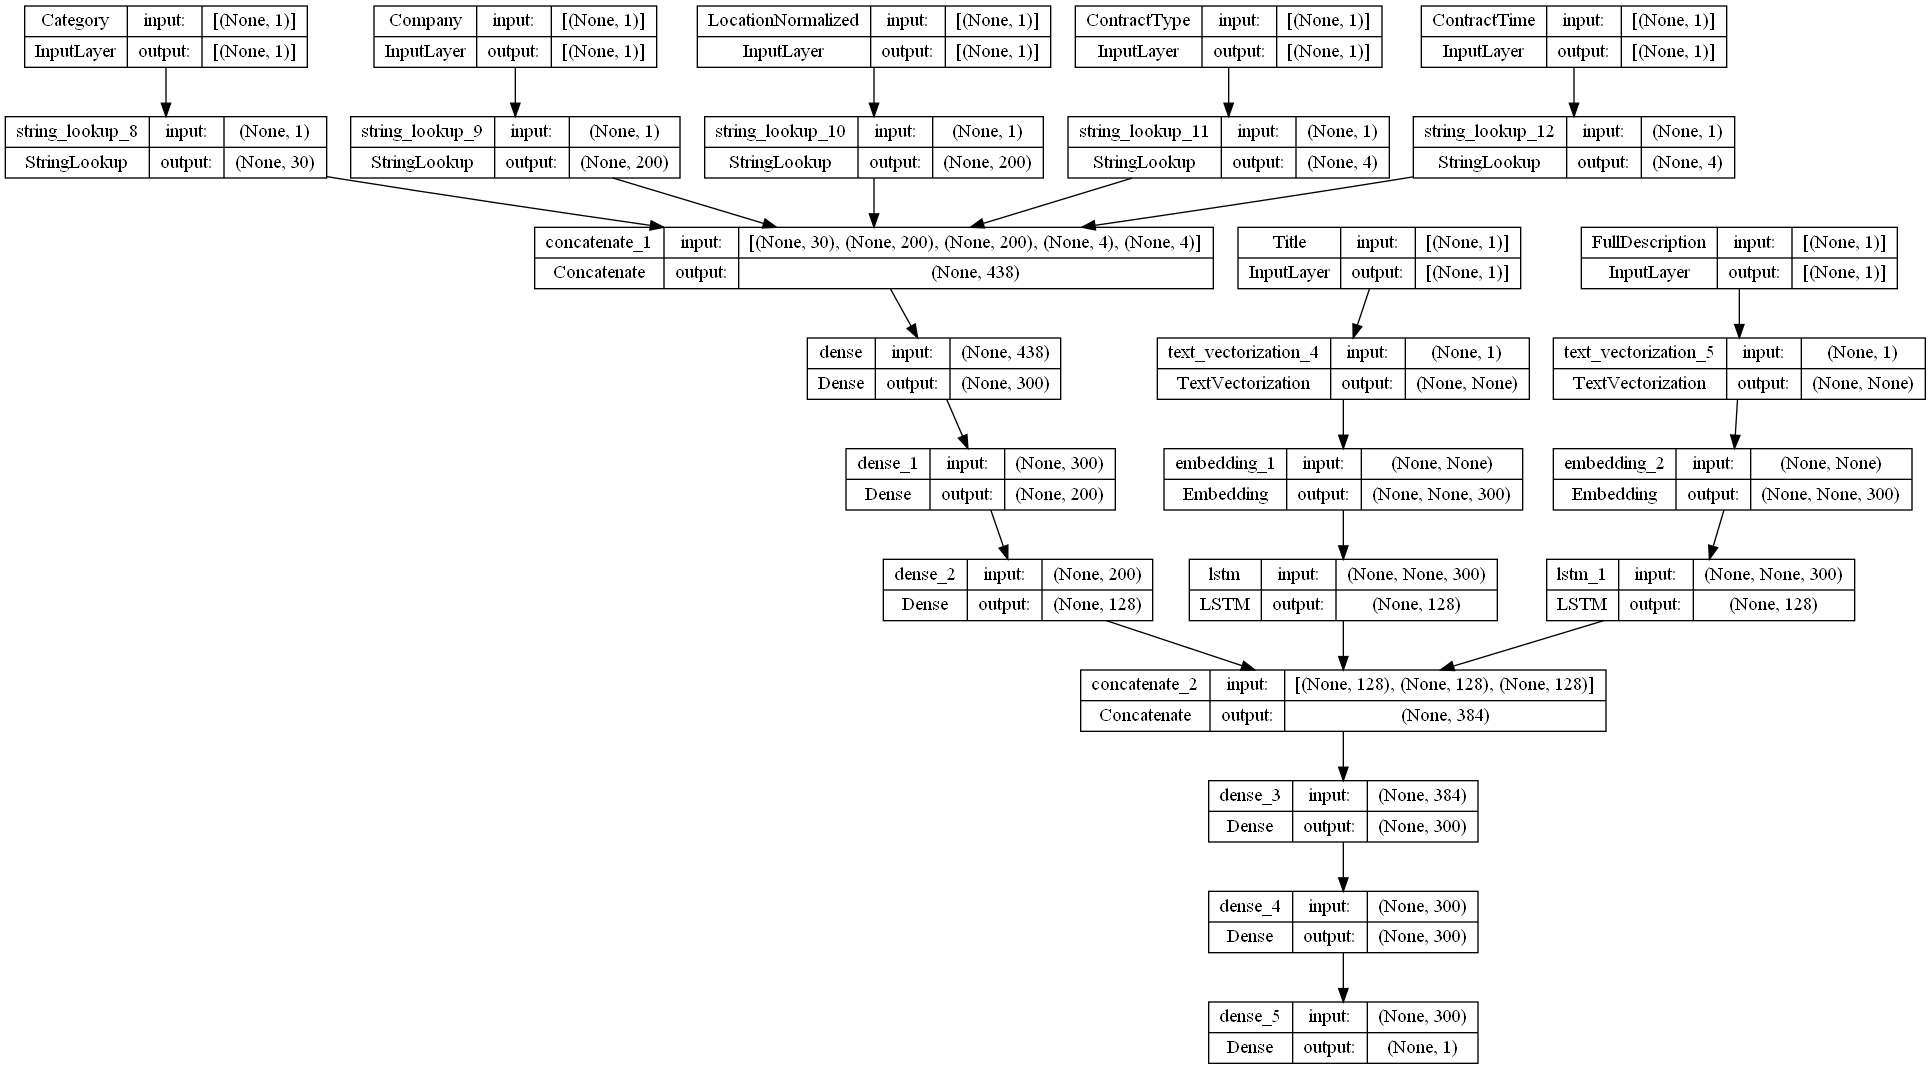

In [39]:
# rnn_model.summary()
keras.utils.plot_model(rnn_model, "rnn_model.png", show_shapes=True)

In [35]:
import os

root_logdir = os.path.join(os.curdir, "logs")

def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'.\\logs\\run_2022_10_16-16_48_27'

In [26]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6016

In [27]:
test_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(test_logdir, )
# writer = tf.summary.create_file_writer(test_logdir)
# with writer.as_default():
#     tf.summary.text("hyperparams", [
#         "Learning rate: " + str(model.optimizer.learning_rate),
#         "n layers: " + str(model.layers),
#     ] + [f"# units layer {i}: " + str(layer.units) for layer in model.layers[1:]],
#     step=1
#                    )
    
# stop when "the best" model was found
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)
# save the best model
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "rnn_model.h5",
#     save_best_only=True
# )
# Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, 
# use `save_format='tf'` instead. 
# Received a model or layer StringLookup with weights 
# [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x0000024088027FD0>]

history = rnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[tensorboard_cb, early_stopping_cb],
)

Epoch 1/1000


C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['Id', 'LocationRaw', 'SourceName'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6543/6885 [===========================>..] - ETA: 13s - loss: 1.0708 - mean_absolute_error: 0.7994

KeyboardInterrupt: 

In [48]:
rnn_model.save('saved_model/my_model')

AttributeError: 'Adam' object has no attribute 'get_slot_names'

In [81]:
def build_birnn_model(merge_mode="ave"):
    """ Build a model that maps three encoded data sources to a single linear output: predicted log1p(salary) """
    title_rnn = keras.layers.Bidirectional(keras.layers.LSTM(128), merge_mode=merge_mode)(title_enc)
    descr_rnn = keras.layers.Bidirectional(keras.layers.LSTM(128), merge_mode=merge_mode)(description_enc)
    
    dense_cat_1 = keras.layers.Dense(units=300, activation="relu")(cat_feats)
    dense_cat_2 = keras.layers.Dense(units=200, activation="relu")(dense_cat_1)
    if merge_mode == "concat":
        dense_cat_3 = keras.layers.Dense(units=2*128, activation="relu")(dense_cat_2)
    else:
        dense_cat_3 = keras.layers.Dense(units=128, activation="relu")(dense_cat_2)
    
    concat = keras.layers.Concatenate(axis=1)([title_rnn, descr_rnn, dense_cat_3])
    dropout_1 = keras.layers.Dropout(0.5)(concat)
    dense_1 = keras.layers.Dense(units=300, activation="relu")(dropout_1)
    dropout_2 = keras.layers.Dropout(0.5)(dense_1)
    dense_2 = keras.layers.Dense(units=300, activation="relu")(dropout_2)
    output_layer = keras.layers.Dense(units=1, activation="linear")(dense_2)
    
    model = keras.models.Model(
        inputs=[
            title, description, 
            category, company,
            location, contract_type,
            contract_time
        ], 
        outputs=[output_layer])
    model.compile(tf.optimizers.Adam(), 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [82]:
birnn_model = build_birnn_model()

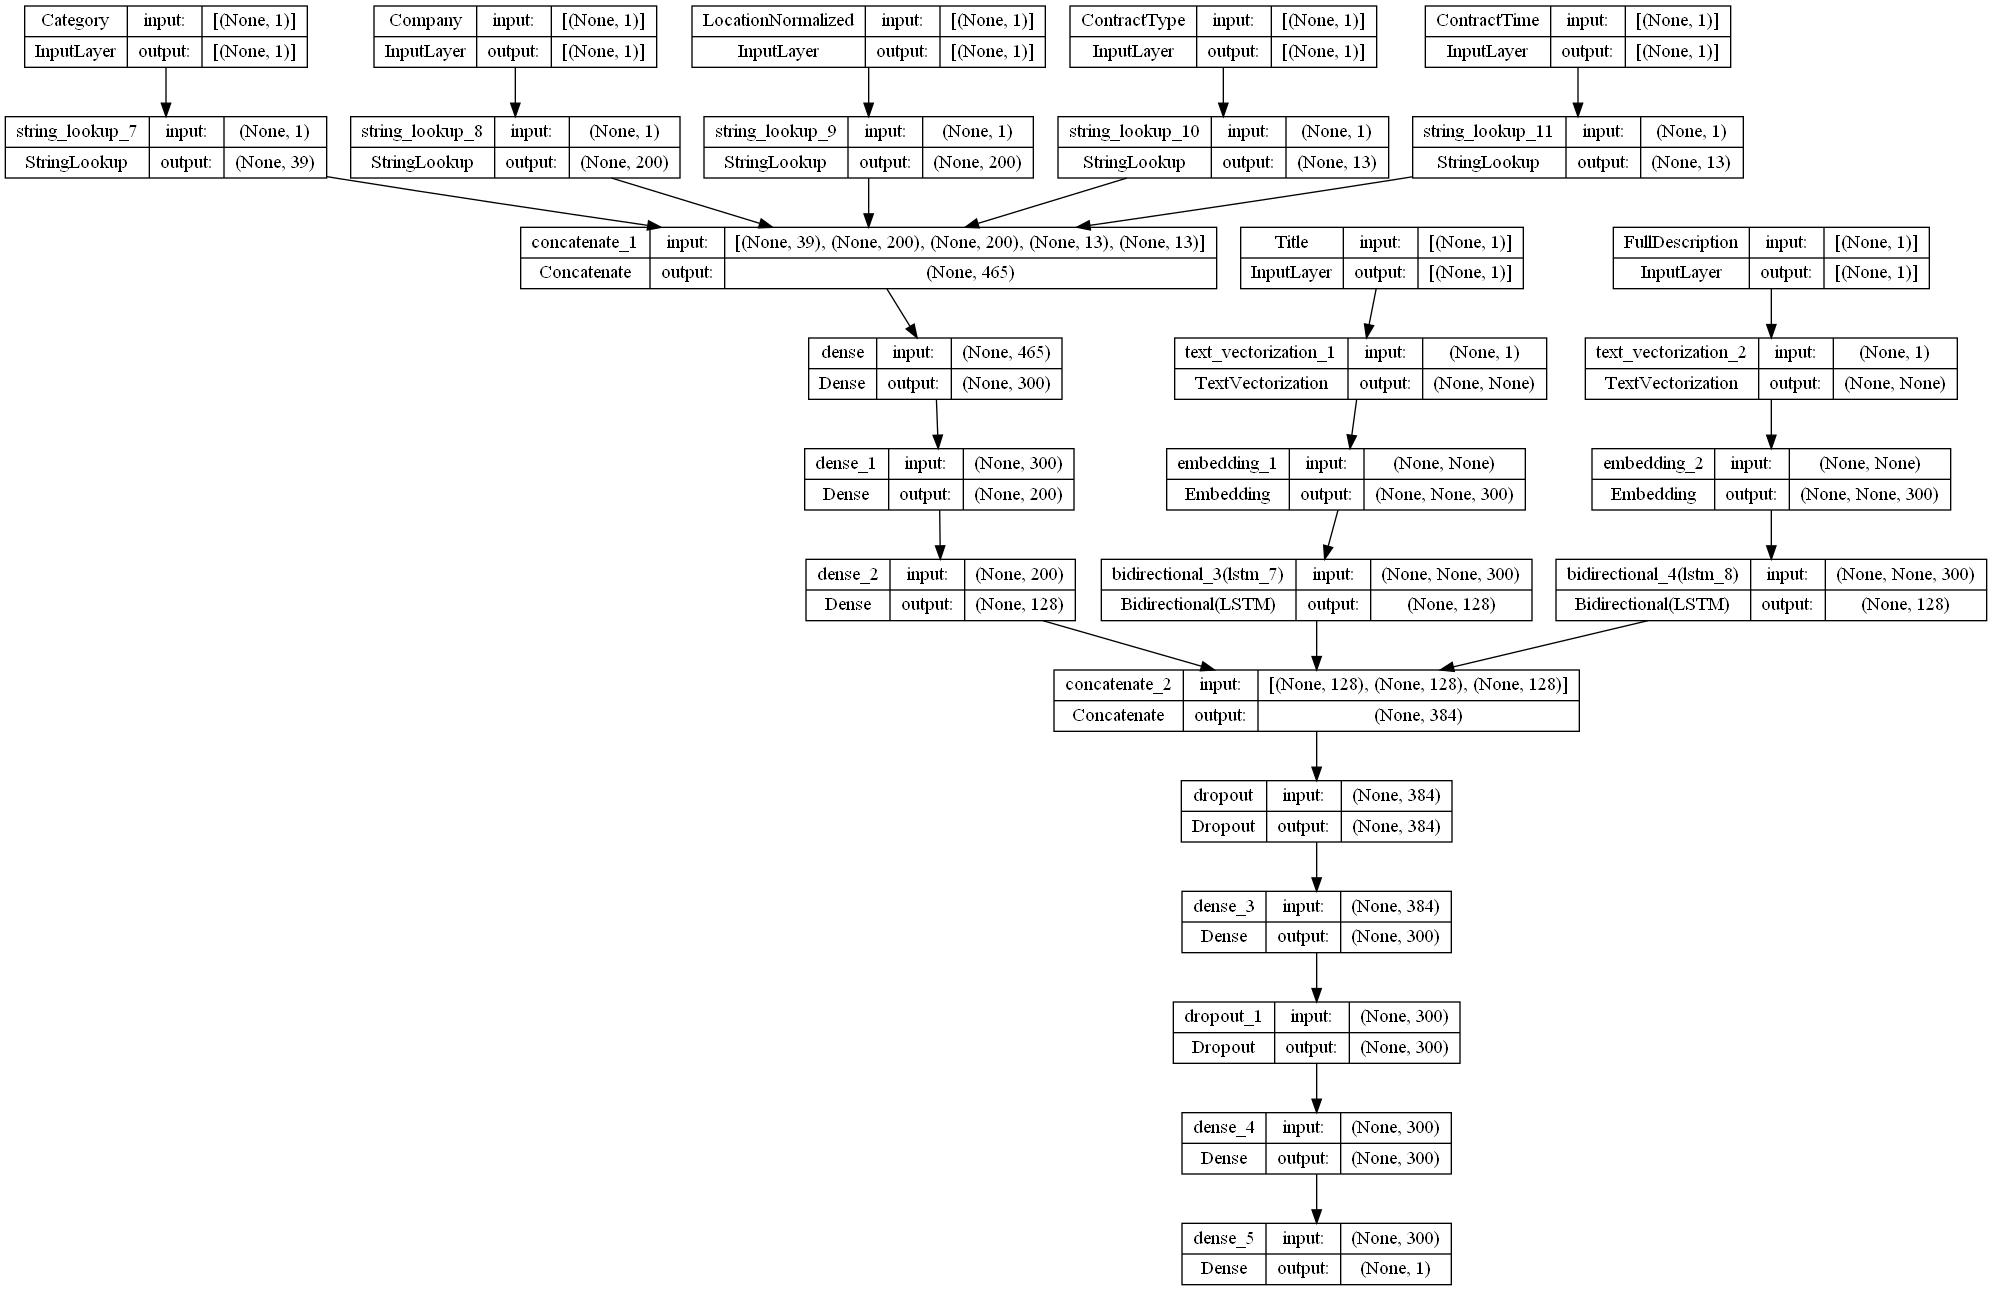

In [83]:
keras.utils.plot_model(birnn_model, "birnn_model.png", show_shapes=True)

In [84]:
%load_ext tensorboard
%tensorboard --logdir=./logs --port=6011

In [ ]:
test_logdir = get_run_logdir()
history = birnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[tensorboard_cb, early_stopping_cb],
)

Epoch 1/1000


C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['Id', 'LocationRaw', 'SourceName'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6885/6885 [==============================] - 551s 78ms/step - loss: 0.4309 - mean_absolute_error: 0.4264 - val_loss: 0.1444 - val_mean_absolute_error: 0.2931
Epoch 2/1000
6885/6885 [==============================] - 523s 76ms/step - loss: 0.0852 - mean_absolute_error: 0.2197 - val_loss: 0.0902 - val_mean_absolute_error: 0.2280
Epoch 3/1000
6885/6885 [==============================] - 517s 75ms/step - loss: 0.0748 - mean_absolute_error: 0.2042 - val_loss: 0.1036 - val_mean_absolute_error: 0.2483
Epoch 4/1000
6885/6885 [==============================] - 518s 75ms/step - loss: 0.0685 - mean_absolute_error: 0.1954 - val_loss: 0.1135 - val_mean_absolute_error: 0.2635
Epoch 5/1000
6651/6885 [===========================>..] - ETA: 16s - loss: 0.0633 - mean_absolute_error: 0.1878

## Word-level cnn
First need to fix sequence lengths

In [24]:
title_enc_fixed_len = encode_text_feature(
    title, "Title", train_ds, 
    wv_model, max_tokens=5000, 
    output_sequence_length=15
)
description_enc_fixed_len = encode_text_feature(
    description, "FullDescription", 
    train_ds, wv_model, max_tokens=20000,
    output_sequence_length=300
)

In [32]:
def build_cnn_model(
    n_layers_title=2,
    init_filters_title=32,  
    init_strides_title=3,
    init_kernel_size_title=3,
    #
    n_layers_descr=5,
    init_filters_descr=64,  
    init_strides_descr=5,
    init_kernel_size_descr=5,
):
    title_cnn = title_enc_fixed_len
    n_filters = init_filters_title
    for i in range(n_layers_title):
        title_cnn = keras.layers.Conv1D(
            n_filters, 
            kernel_size=init_kernel_size_title if i == 0 else 3, 
            strides=init_strides_title if i == 0 else 1, 
            padding="valid" if i == 0 else "same"
        )(title_cnn)
        title_cnn = keras.layers.BatchNormalization()(title_cnn)
        title_cnn = keras.layers.ReLU()(title_cnn)
        title_cnn = keras.layers.MaxPooling1D(2)(title_cnn)
        n_filters *= 2
    title_cnn = keras.layers.Flatten()(title_cnn)
    
    
    descr_cnn = description_enc_fixed_len
    n_filters = init_strides_descr 
    for i in range(n_layers_title):
        descr_cnn = keras.layers.Conv1D(
            n_filters, 
            kernel_size=init_kernel_size_descr if i == 0 else 3, 
            strides=init_strides_title if i == 0 else 1, 
            padding="valid" if i == 0 else "same"
        )(descr_cnn)
        descr_cnn = keras.layers.BatchNormalization()(descr_cnn)
        descr_cnn = keras.layers.ReLU()(descr_cnn)
        descr_cnn = keras.layers.MaxPooling1D()(descr_cnn)
        n_filters *= 2
    descr_cnn = keras.layers.Flatten()(descr_cnn)
    
    # equalize dimensions
    print("descr dim: ", descr_cnn.shape[1], "title dim: ", title_cnn.shape[1])
    if descr_cnn.shape[1] > title_cnn.shape[1]:
        descr_cnn = keras.layers.Dense(units=title_cnn.shape[1], activation="relu")(descr_cnn)
    else:
        title_cnn = keras.layers.Dense(units=descr_cnn.shape[1], activation="relu")(title_cnn)
    
    dense_cat_1 = keras.layers.Dense(units=300, activation="relu")(cat_feats)
    dense_cat_2 = keras.layers.Dense(units=200, activation="relu")(dense_cat_1)
    dense_cat_3 = keras.layers.Dense(units=title_cnn.shape[1], activation="relu")(dense_cat_2)
    
    concat = keras.layers.Concatenate(axis=1)([title_cnn, descr_cnn, dense_cat_3])
    dropout_1 = keras.layers.Dropout(0.5)(concat)
    dense_1 = keras.layers.Dense(units=300, activation="relu")(dropout_1)
    dropout_2 = keras.layers.Dropout(0.5)(dense_1)
    dense_2 = keras.layers.Dense(units=300, activation="relu")(dropout_2)
    output_layer = keras.layers.Dense(units=1, activation="linear")(dense_2)
    
    model = keras.models.Model(
        inputs=[
            title, description, 
            category, company,
            location, contract_type,
            contract_time
        ], 
        outputs=[output_layer])
    model.compile(tf.optimizers.Adam(), 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [33]:
word_cnn_model = build_cnn_model()

descr dim:  240 title dim:  64


In [36]:
test_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(test_logdir, histogram_freq=1)
# writer = tf.summary.create_file_writer(test_logdir)
# with writer.as_default():
#     tf.summary.text("hyperparams", [
#         "Learning rate: " + str(model.optimizer.learning_rate),
#         "n layers: " + str(model.layers),
#     ] + [f"# units layer {i}: " + str(layer.units) for layer in model.layers[1:]],
#     step=1
#                    )
    
# stop when "the best" model was found
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)
# save the best model
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "rnn_model.h5",
#     save_best_only=True
# )
# Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, 
# use `save_format='tf'` instead. 
# Received a model or layer StringLookup with weights 
# [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x0000024088027FD0>]

history = word_cnn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[tensorboard_cb, early_stopping_cb],
)

Epoch 1/1000


C:\Users\леопольд\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\engine\functional.py:637: UserWarning: Input dict contained keys ['Id', 'LocationRaw', 'SourceName'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


6885/6885 [==============================] - 136s 18ms/step - loss: 0.5723 - mean_absolute_error: 0.5014 - val_loss: 0.1563 - val_mean_absolute_error: 0.3058
Epoch 2/1000
6885/6885 [==============================] - 126s 18ms/step - loss: 0.1084 - mean_absolute_error: 0.2512 - val_loss: 0.1228 - val_mean_absolute_error: 0.2681
Epoch 3/1000
6885/6885 [==============================] - 127s 18ms/step - loss: 0.0942 - mean_absolute_error: 0.2323 - val_loss: 0.1164 - val_mean_absolute_error: 0.2632
Epoch 4/1000
6885/6885 [==============================] - 127s 19ms/step - loss: 0.0862 - mean_absolute_error: 0.2215 - val_loss: 0.1195 - val_mean_absolute_error: 0.2686
Epoch 5/1000
6885/6885 [==============================] - 127s 18ms/step - loss: 0.0811 - mean_absolute_error: 0.2144 - val_loss: 0.1063 - val_mean_absolute_error: 0.2511
Epoch 6/1000
6885/6885 [==============================] - 127s 18ms/step - loss: 0.0773 - mean_absolute_error: 0.2092 - val_loss: 0.1034 - val_mean_absolute_e

KeyboardInterrupt: 

## Character-level deep cnn

In [43]:
import gensim 
from keras.layers import TextVectorization
from keras.layers import Embedding

def encode_text_feature_char_level(
    feature, name, dataset, 
    output_sequence_length=500,
    max_tokens=50, embedding_dim=50
):
    """
    Uses one-hot instead of embedding layer. 
    Therefore, doesn't rely on pretrained models.
    """
    vectorizer = TextVectorization(
        max_tokens=max_tokens, split="character",
        output_sequence_length=output_sequence_length
    )
    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    vectorizer.adapt(feature_ds)
    vectorized_feature = vectorizer(feature)
    return tf.one_hot(vectorized_feature, len(vectorizer.get_vocabulary()))

In [44]:
title_enc_char_level = encode_text_feature_char_level(
    title, "Title", 
    train_ds, max_tokens=50, 
    output_sequence_length=500
)
description_enc_char_level = encode_text_feature_char_level(
    description, "FullDescription", 
    train_ds, max_tokens=50,
    output_sequence_length=300*10
)

Problem: we've lost masking, which was in `Embedding` layer

In [95]:
class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            keras.layers.Conv1D(filters, kernel_size=3, strides=strides, padding="same"),
            keras.layers.BatchNormalization(),
            self.activation,
            keras.layers.Conv1D(filters, kernel_size=3, strides=1, padding="same"),
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                keras.layers.Conv1D(filters, kernel_size=1, strides=strides, padding="same"),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [96]:
def build_char_cnn_model(
    init_filters_title=16,  
    init_strides_title=3,
    init_kernel_size_title=10,
    #
    init_filters_descr=32,  
    init_strides_descr=10,
    init_kernel_size_descr=20,
):
    title_cnn = title_enc_char_level
    print("init:", title_cnn.shape[1])
    title_cnn = keras.layers.Conv1D(
        init_filters_title,
        init_kernel_size_title,
        strides=init_strides_title,
    )(title_cnn)
    title_cnn = keras.layers.BatchNormalization()(title_cnn)
    title_cnn = keras.layers.ReLU()(title_cnn)
    title_cnn = keras.layers.MaxPooling1D(2)(title_cnn)
    print("after first conv:", title_cnn.shape[1])
    prev_filters = title_cnn.shape[1]
    #
    for filters in [init_filters_title] * 1 + [init_filters_title*2] * 2 + [init_filters_title*4] * 3 + [init_filters_title*8] * 1:
        strides = 1 if filters == prev_filters else 2
        print(strides, filters, title_cnn.shape)
        title_cnn = ResidualUnit(filters, strides=strides)(title_cnn)
        prev_filters = filters
    title_cnn = keras.layers.GlobalAveragePooling1D()(title_cnn)
        
    descr_cnn = description_enc_char_level
    descr_cnn = keras.layers.Conv1D(
        init_filters_descr, 
        init_kernel_size_descr,
        strides=init_strides_descr
    )(descr_cnn)
    descr_cnn = keras.layers.BatchNormalization()(descr_cnn)
    descr_cnn = keras.layers.ReLU()(descr_cnn)
    descr_cnn = keras.layers.MaxPooling1D(2)(descr_cnn)
    prev_filters = descr_cnn.shape[1]
    # 
    for filters in [init_filters_descr] * 1 + [init_filters_descr*2] * 2 + [init_filters_descr*4] * 3 + [init_filters_descr*8] * 1:
        strides = 1 if filters == prev_filters else 2
        print(strides, filters, descr_cnn.shape)
        descr_cnn = ResidualUnit(filters, strides=strides)(descr_cnn)
        prev_filters = filters
    descr_cnn = keras.layers.GlobalAveragePooling1D()(descr_cnn)
    
    # equalize dimensions
    print("descr dim: ", descr_cnn.shape[1], "title dim: ", title_cnn.shape[1])
    if descr_cnn.shape[1] > title_cnn.shape[1]:
        descr_cnn = keras.layers.Dense(units=title_cnn.shape[1], activation="relu")(descr_cnn)
    else:
        title_cnn = keras.layers.Dense(units=descr_cnn.shape[1], activation="relu")(title_cnn)
    
    dense_cat = keras.layers.Dense(units=300, activation="relu")(cat_feats)
    dense_cat = keras.layers.Dense(units=200, activation="relu")(dense_cat)
    dense_cat = keras.layers.Dense(units=title_cnn.shape[1], activation="relu")(dense_cat)
    
    concat = keras.layers.Concatenate(axis=1)([title_cnn, descr_cnn, dense_cat])
    dropout_1 = keras.layers.Dropout(0.5)(concat)
    dense_1 = keras.layers.Dense(units=300, activation="relu")(dropout_1)
    dropout_2 = keras.layers.Dropout(0.5)(dense_1)
    dense_2 = keras.layers.Dense(units=300, activation="relu")(dropout_2)
    dropout_3 = keras.layers.Dropout(0.5)(dense_2)
    output_layer = keras.layers.Dense(units=1, activation="linear")(dropout_3)
    
    model = keras.models.Model(
        inputs=[
            title, description, 
            category, company,
            location, contract_type,
            contract_time
        ], 
        outputs=[output_layer])
    model.compile(tf.optimizers.Adam(), 'mean_squared_error', metrics=['mean_absolute_error'])
    return model

In [97]:
cnn_char_model = build_char_cnn_model()

init: 500
after first conv: 82
2 16 (None, 82, 16)
2 32 (None, 41, 16)
1 32 (None, 21, 32)
2 64 (None, 21, 32)
1 64 (None, 11, 64)
1 64 (None, 11, 64)
2 128 (None, 11, 64)
2 32 (None, 149, 32)
2 64 (None, 75, 32)
1 64 (None, 38, 64)
2 128 (None, 38, 64)
1 128 (None, 19, 128)
1 128 (None, 19, 128)
2 256 (None, 19, 128)
descr dim:  256 title dim:  128


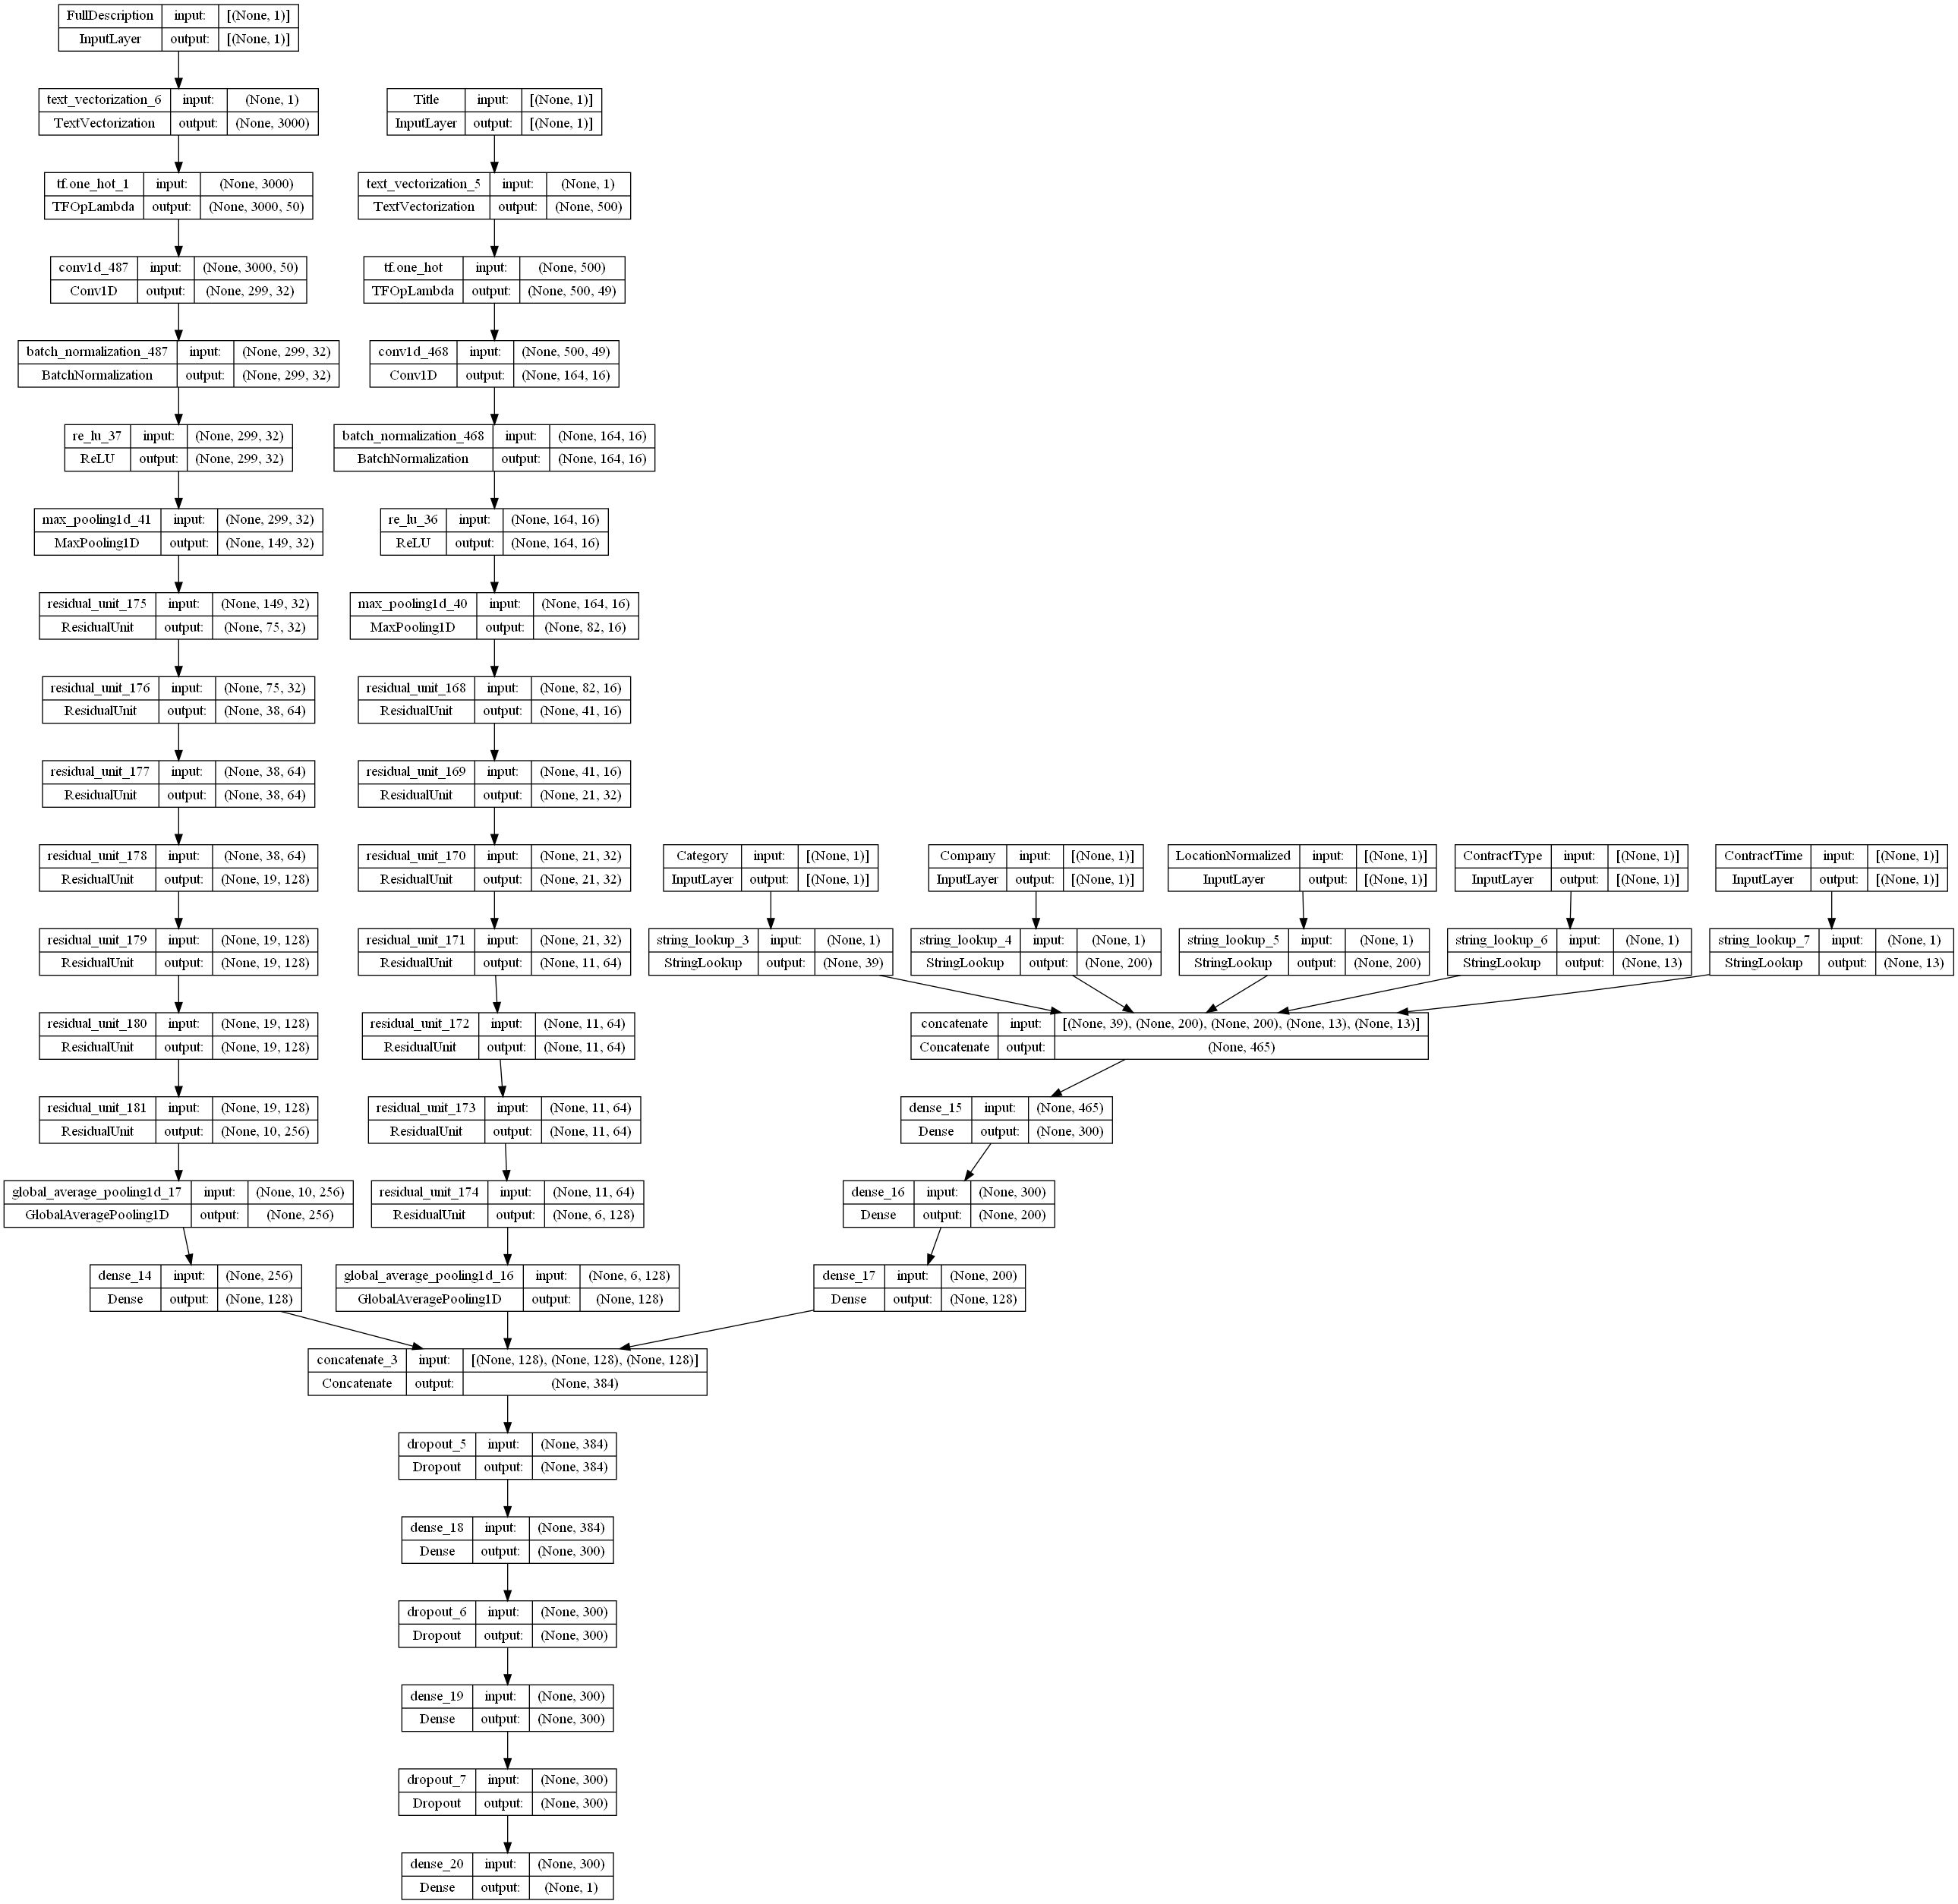

In [99]:
keras.utils.plot_model(cnn_char_model, "cnn_char_model.png", show_shapes=True)

In [100]:
test_logdir = get_run_logdir()
tensorboard_cb = keras.callbacks.TensorBoard(test_logdir)
# writer = tf.summary.create_file_writer(test_logdir)
# with writer.as_default():
#     tf.summary.text("hyperparams", [
#         "Learning rate: " + str(model.optimizer.learning_rate),
#         "n layers: " + str(model.layers),
#     ] + [f"# units layer {i}: " + str(layer.units) for layer in model.layers[1:]],
#     step=1
#                    )
    
# stop when "the best" model was found
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True
)
# save the best model
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     "rnn_model.h5",
#     save_best_only=True
# )
# Save or restore weights that is not an instance of `tf.Variable` is not supported in h5, 
# use `save_format='tf'` instead. 
# Received a model or layer StringLookup with weights 
# [<keras.layers.preprocessing.index_lookup.VocabWeightHandler object at 0x0000024088027FD0>]

history = cnn_char_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1000,
    callbacks=[tensorboard_cb, early_stopping_cb],
)

Layer ResidualUnit has arguments ['filters', 'strides', 'activation']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Layer ResidualUnit has arguments ['filters', 'strides', 'activation']
in `__init__` and therefore must override `get_config()`.

Example:

class CustomLayer(keras.layers.Layer):
    def __init__(self, arg1, arg2):
        super().__init__()
        self.arg1 = arg1
        self.arg2 = arg2

    def get_config(self):
        config = super().get_config()
        config.update({
            "arg1": self.arg1,
            "arg2": self.arg2,
        })
        return config


Epoch 1/1000
6885/6885 [==============================] - 567s 82ms/step - loss: 0.4816 - mean_absolute_error: 0.5508 - val_loss: 0.2470 - val_mean_absolute_error: 0.3964
Epoch 2/1000
2409/6885 [=========>....................] - ETA: 5:54 - loss: 0.3570 - mean_absolute_error: 0.4740

KeyboardInterrupt: 

## Summary

Compared to classical methods the result has improved by ~0.1 MAE.